<a href="https://colab.research.google.com/github/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential Regression

---
Antoine Savine, April 2020
---


This notebook applies differential learning in the context of classic regression models. It is meant as a complement to the article 'Learning the Shape: Differential Machine Learning' by Huge and Savine (Risk, 2020), which explored the new ideas of twin networks and differential training, mainly in the context of deep neural networks. The article hinted that the methodology applies to arbitrary regression models, including classic linear regression and neural architectures of arbitrary complexity, but did not show other numerical results than feedforward networks, leaving extensions for online additional material. 

This notebook substantiates the claim and applies the methodology to polynomial regression in the context of a basket option in a correlated Bachelier model, the same context as the first numerical example in the article. We see that, in this context too, differential training provides a  massive performance improvement, compared, not only with standard regression, but also, with ridge (Tikhonov) regularization, optimized by cross-validation. Optimized ridge regression consumes significant additional data and computation load, and it definitely improves the performance of the standard regression. Differential regression, however, performs a lot better, and without the need for additional regularization, or hyperparameter optimization.

Please execute the code cells in order and configure your simulations in the cell 'parameters', including Bachelier / basket dimension, polynomial degrees, training sizes, and simulation seed.

Although the notebook implements polynomial regression over Bachelier basket data, it is easy to change the simulation model, financial instrument and regression basis, for example to implement an Asian option in Black and Scholes with a radial basis regression... More complicated, real-world models and instruments cannot be correctly implemented in numpy, for that we would need a complete financial Derivatives library in C++ or TensorFlow.

Textbook regression is often implemented analytically with normal equations, or numerically with gradient descent. In low to medium dimension (1 to less than 10 in practice), the best results are obtained with SVD regression, which stabilises the analytic normal equations by removing insignificant singular values / eigenvalues. The notebook implements the formulas found in [this memo](https://github.com/differential-machine-learning/appendices/blob/master/DifferentialRegression.pdf), based on eigenvalue decomposition.

For polynomial regression over Bachelier basket data, the performance of various forms of regression varies depending on the Bachelier correlation matrix, which is randomly re-generated on every run. Interestingly, we don't have this problem with the neural networks implemented in the original paper, their performance is consistent and resilient to changes of model parameters. Although performance is variable with polynomial regression, differential regression consistently outperforms by a vast amount every time.

# Imports

In [2]:
%matplotlib inline

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# Bachelier pricer/simulator
---
Simulates a training set of basket payoff samples along with pathwise differentials and a test set of ground truth values, deltas and vegas

In [3]:
# helper analytics
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return  vol * np.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return np.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(n):
    randoms = np.random.uniform(low=-1., high=1., size=(2*n, n))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])

# main class
class Bachelier:
    
    def __init__(self, 
                 n,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1):
        
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    def trainingSet(self, m, anti=True, seed=None, bktVol=0.2):
    
        np.random.seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = np.repeat(1., self.n)
        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = np.random.uniform(low=1., high=10., size=self.n)
        self.a /= np.sum(self.a)
        # random vols
        vols = np.random.uniform(low=5., high = 50., size = self.n)
        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        avols = (self.a * vols).reshape((-1,1))
        v = np.sqrt(np.linalg.multi_dot([avols.T, self.corr, avols]).reshape(1))
        self.vols = vols * bktVol / v
        self.bktVol = bktVol

        # Choleski etc. for simulation
        diagv = np.diag(self.vols)
        self.cov = np.linalg.multi_dot([diagv, self.corr, diagv])
        self.chol = np.linalg.cholesky(self.cov) * np.sqrt(self.T2 - self.T1)
        # increase vols for simulation of X so we have more samples in the wings
        self.chol0 = self.chol * self.volMult * np.sqrt(self.T1 / (self.T2 - self.T1))
        # simulations
        normals = np.random.normal(size=[2, m, self.n])
        inc0 = normals[0, :, :] @ self.chol0.T
        inc1 = normals[1, :, :] @ self.chol.T
    
        S1 = self.S0 + inc0
        
        S2 = S1 + inc1
        bkt2 = np.dot(S2, self.a)
        pay = np.maximum(0, bkt2 - self.K)

        # two antithetic paths
        if anti:
            
            S2a = S1 - inc1
            bkt2a = np.dot(S2a, self.a)
            paya = np.maximum(0, bkt2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z2 =  np.where(bkt2a > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            
        return X, Y.reshape((-1,1)), Z
    
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.50, upper=1.50, num=4096, seed=None):
        np.random.seed(seed)
        spots = np.random.uniform(low=lower, high = upper, size=(num, self.n))
        baskets = np.dot(spots, self.a).reshape((-1, 1))
        prices = bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1)
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) @ self.a.reshape((1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices.reshape((-1, 1)), deltas, vegas


# Polynomial regressor
---
Implements SVD (actually, eigenvalue) based regressions formulas [found here](https://github.com/differential-machine-learning/appendices/blob/master/DifferentialRegression.pdf) for standard, ridge and differential polynomial regression


In [4]:
class PolyReg:

  # compute all the polynomials we are going to need
  def __init__(self, xTrain, yTrain, dydxTrain, validSize, xTest, yTest, dydxTest, maxDeg):
    
    # store

    self.X = xTrain
    self.Y = yTrain
    self.dYdX = dydxTrain

    self.tx = xTest
    self.ty = yTest         
    self.tdydx = dydxTest   

    # split

    # train set
    self.ax = self.X[:-validSize, :]
    self.ay = self.Y[:-validSize, :]
    self.adydx = self.dYdX[:-validSize, :]

    # valid set
    self.vx = self.X[-validSize:, :]
    self.vy = self.Y[-validSize:, :]
    self.vdydx = self.dYdX[-validSize:, :]

    # monomials

    # generator, without constant
    self.maxDeg = maxDeg
    self.polGen = PolynomialFeatures(degree=maxDeg, include_bias=False)
    
    # train
    self.aphi = self.polGen.fit_transform(self.ax)
    # valid
    self.vaphi = self.polGen.transform(self.vx)
    # test
    self.taphi = self.polGen.transform(self.tx)
    
    # powers, degrees
    self.powers = self.polGen.powers_
    self.degrees = np.sum(self.powers, axis=1)

    # dphi: differentials of monomials to inputs, of shape (num examples x num monomials x num inputs)
    # train
    self.adphidx = self.aphi[:, :, np.newaxis] * self.powers[np.newaxis, :, :] / (self.ax[:, np.newaxis, :] + 1.0e-08)
    # valid
    self.vadphidx = self.vaphi[:, :, np.newaxis] * self.powers[np.newaxis, :, :] / (self.vx[:, np.newaxis, :] + 1.0e-08)
    # test
    self.tadphidx = self.taphi[:, :, np.newaxis] * self.powers[np.newaxis, :, :] / (self.tx[:, np.newaxis, :] + 1.0e-08)

  # prepare regression of degree p on m examples
  def prepare(self, p, m):
    
    # crop degrees
    self.indices = np.argwhere(self.degrees <= p).reshape(-1)
    
    # crop and center data
    # train phi
    self.x = self.ax[:m, :]
    phi = self.aphi[:m, self.indices]
    self.muphi = phi.mean(axis=0).reshape(1, -1)
    self.phi = phi - self.muphi
    # train y
    y = self.ay[:m, :]
    self.muy = y.mean()
    self.y = y - self.muy
    # train derivs
    self.dydx = self.adydx[:m, :]
    self.dphidx = self.adphidx[:m, self.indices, :]
    
    # valid
    self.vphi = self.vaphi[:, self.indices] - self.muphi
    self.vdphidx = self.vadphidx[:, self.indices, :]

    # test
    self.tphi = self.taphi[:, self.indices] - self.muphi
    self.tdphidx = self.tadphidx[:, self.indices, :]

    # weight the train derivs for cost function
    self.lamj = (y.var() / (self.dydx ** 2).mean(axis=0)).reshape(1, 1, -1)
    self.dphidxw = self.dphidx * np.sqrt(self.lamj)

  # regress
  def regress(self, tikLambda = 0, eigCut = 1.0e-08):
            
      # eigenvalue regression 
      d, p = np.linalg.eigh(self.phi.T @ self.phi)
      
      # cut small eigenvalues
      cut = eigCut * d.mean()
      invD = np.where(d>cut, 1/(d + tikLambda ** 2), 0).reshape(1, -1)
      
      # result, see note
      return ((p * invD) @ p.T @ self.phi.T @ self.y).reshape(-1, 1)    
      
  # find best tikhonov lambda by cross validation
  def crossValidate(self):
    
    # objective function
    def obj(tikLambda):
      if tikLambda < 0:
        return obj(0) * (1 + tikLambda ** 2)
      beta = self.regress(tikLambda)
      validErrors = self.validValues(beta) - self.vy
      mse = np.mean(validErrors ** 2)
      return mse 
    
    # optimize
    tikLambda = minimize_scalar(obj, tol=1.0e-02).x

    # regress
    return self.regress(tikLambda)

  # differential regress, see memo
  def diffRegress(self, diffLambda = 1, eigCut = 1.0e-08):

    # sums over j of phij.T phij and phijT Zj
    phiTphi = np.tensordot(self.dphidxw, self.dphidx, axes=([0,2],[0,2]))
    phiTz = np.tensordot(self.dphidxw, self.dydx, axes=([0,2],[0,1])).reshape(-1,1)
    
    # eigenvalue regression
    d, p = np.linalg.eigh(self.phi.T @ self.phi + diffLambda * phiTphi)
  
    # cut small eigenvalues
    cut = eigCut * d.mean()
    invD = np.where(d>cut, 1/d, 0).reshape(1, -1)
  
    # eigenvalue regression result
    return ((p * invD) @ p.T @ (self.phi.T @ self.y + diffLambda * phiTz)).reshape(-1, 1)    
              

  # predict values and derivs
  def predictValues(self, beta, phi):
      return phi @ beta + self.muy
  
  def predictDerivs(self, beta, dphidx):
      return np.tensordot(dphidx, beta, (1, 0)).reshape(dphidx.shape[0], -1)

  # results on valid set, values
  def validValues(self, beta):
      return self.predictValues(beta, self.vphi)

  # results on test set, values
  def testValues(self, beta):
      return self.predictValues(beta, self.tphi)
    
  # results on test set, deltas
  def testDerivs(self, beta):
      return self.predictDerivs(beta, self.tdphidx)

# Testing Functions
---
Perform multiple regressions in many different configurations at once, and show results in charts


In [5]:
def test(dim, maxNtrain, simulSeed, nTest, testSeed, validSize, degs, sizes , deltidx=0, doTikhonov=True):

    # simulation
    print("simulating training, valid and test sets")
    bach = Bachelier(dim)
    xTrain, yTrain, dydxTrain = bach.trainingSet(maxNtrain, seed=simulSeed)
    xTest, xAxis, yTest, dydxTest, vegas = bach.testSet(num=nTest, seed=testSeed)
    print("done")

    # regressor
    print("computing monomials")
    regressor = PolyReg(xTrain, yTrain, dydxTrain, validSize, xTest, yTest, dydxTest, max(degs))
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
        for deg in degs:
            
            print("doing size %d, degree %d" % (size, deg))
            print("prep regressor")
            regressor.prepare(deg, size)
            print("done")
                
            print("standard regression")
            beta = regressor.regress()
            predictions = regressor.testValues(beta)            
            deltas = regressor.testDerivs(beta)
            predvalues[("standard", size, deg)] = predictions
            preddeltas[("standard", size, deg)] = deltas[:, deltidx]
            print("done")            
            
            print("differential regression")
            beta2 = regressor.diffRegress()
            predictions2 = regressor.testValues(beta2)
            deltas2 = regressor.testDerivs(beta2)
            predvalues[("differential", size, deg)] = predictions2
            preddeltas[("differential", size, deg)] = deltas2[:, deltidx]
            print("done")            
            
            if doTikhonov:
                print("ridge regression by cross validation")
                beta3 = regressor.crossValidate()
                predictions3 = regressor.testValues(beta3)
                deltas3 = regressor.testDerivs(beta3)
                print("done")            

                predvalues[("tikhonov", size, deg)] = predictions3
                preddeltas[("tikhonov", size, deg)] = deltas3[:, deltidx]
            


    return xAxis, yTest, dydxTest[:, deltidx], vegas, predvalues, preddeltas


In [6]:
def graph(title, predictions, xAxis, xAxisName, yAxisName, targets, regType, degs, sizes, computeRmse=False, weights=None):
    
    numRows = len(sizes)
    numCols = len(degs)

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    for j, deg in enumerate(degs):
        ax[0,j].set_title("degree %d" % deg)
  
    for i, size in enumerate(sizes):        
        for j, deg in enumerate(degs):

            if computeRmse:
                errors = predictions[(regType, size, deg)] - targets
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.1f vegas" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size, deg)]*100, 'co', markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.suptitle("% s -- %s in %s regression" % (title, yAxisName, regType), fontsize=16)
    plt.show()

<a id='parameters'></a>
# Parameters
---
Configure your simulations here, including Bachelier / basket dimension, polynomial degrees, training sizes, and simulation seed


In [7]:
# dimension of the basket / Bachelier model -- note maximum regression can handle is 7 dimension with degree 5
basketDim = 7   

# polynomial degrees and simulation set sizes to perform
degs = [3,5] 
sizes = [1024, 8192, 32768]
validSize=8192 # for tikhonov cross-validation

# Tikhonov/Ridge is slow with cross-validation
# set to False to perform all regression in seconds
# as opposed to up to a minute 
doTikhonov = True 
showDeltas = True
deltidx = 0   # which delta to show?

# no not edit
maxNtrain = max(sizes) + (validSize if doTikhonov else 0)

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
# testSeed = 4321
testSeed = None

# number of test scenarios
nTest = 4096

using seed 589


# Results

In [ ]:
# performs all requested regressions and collects results

xAxis, yTest, dydxTest, vegas, values, deltas = \
  test(basketDim, maxNtrain, simulSeed, nTest, testSeed, validSize, degs, sizes, deltidx, doTikhonov)


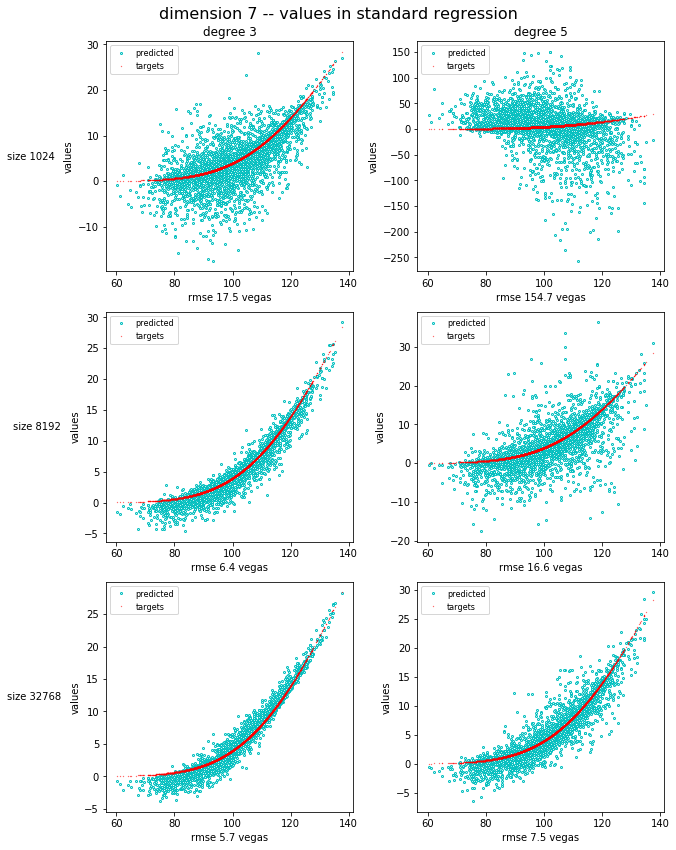

In [9]:
# standard regression value chart
graph("dimension %d" % basketDim, values, xAxis, "", "values", yTest, "standard", degs, sizes, computeRmse=True, weights=vegas/100)

In [ ]:
# standard regression delta chart
if showDeltas:
    graph("dimension %d" % basketDim, deltas, xAxis, "basket", "deltas", dydxTest, "standard", degs, sizes)

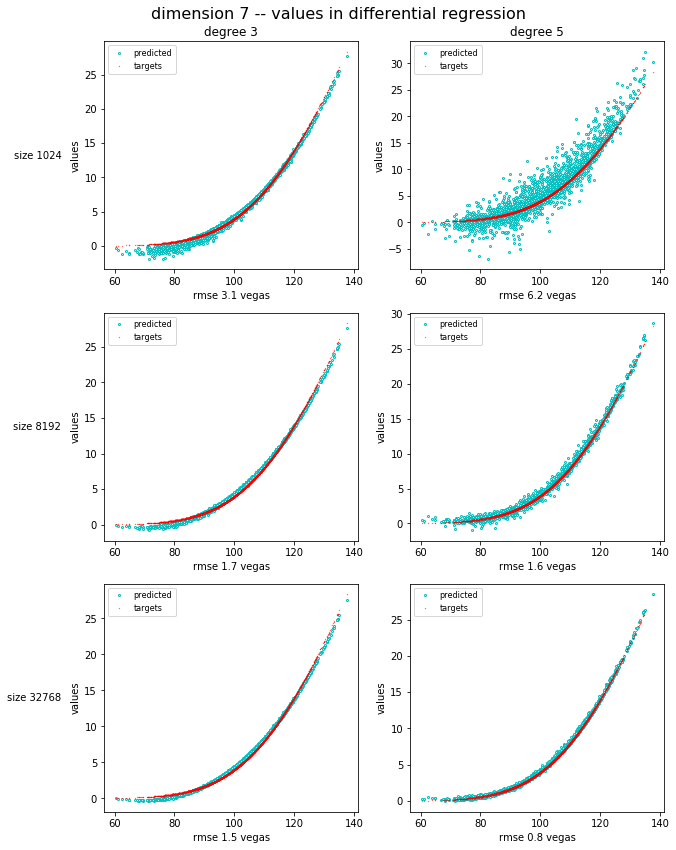

In [10]:
# differential regression value chart
graph("dimension %d" % basketDim, values, xAxis, "", "values", yTest, "differential", degs, sizes, computeRmse=True, weights=vegas/100)

In [ ]:
# differential regression delta chart
graph("dimension %d" % basketDim, deltas, xAxis, "basket", "deltas", dydxTest, "differential", degs, sizes)

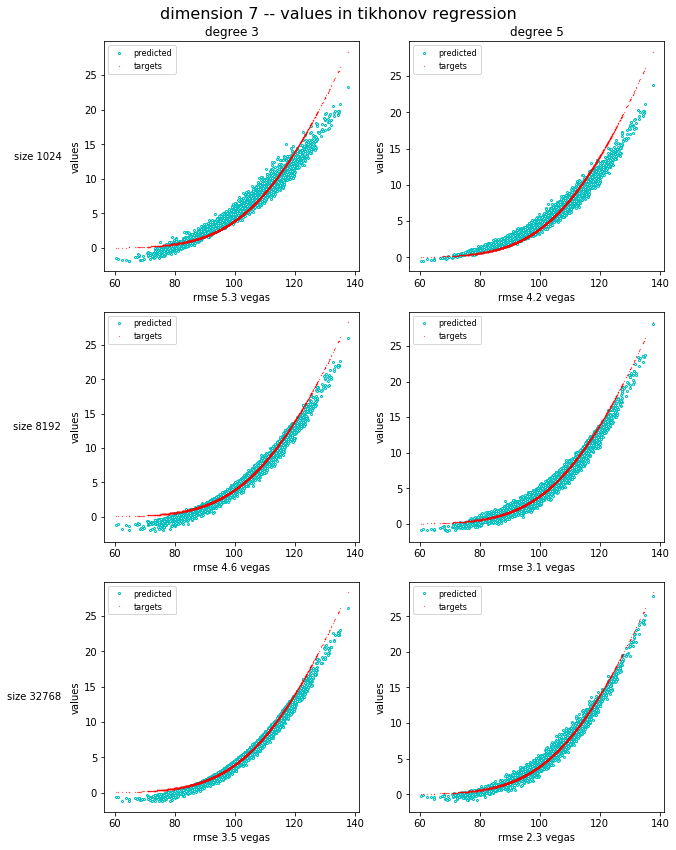

In [11]:
# ridge regression value charts
if doTikhonov:
    graph("dimension %d" % basketDim, values, xAxis, "", "values", yTest, "tikhonov", degs, sizes, computeRmse=True, weights=vegas/100)

In [ ]:
# ridge regression delta charts
if doTikhonov and showDeltas:
        graph("dimension %d" % basketDim, deltas, xAxis, "basket", "deltas", dydxTest, "tikhonov", degs, sizes)